In [14]:
!pip install pycocotools
!pip install torch torchvision torchaudio


loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


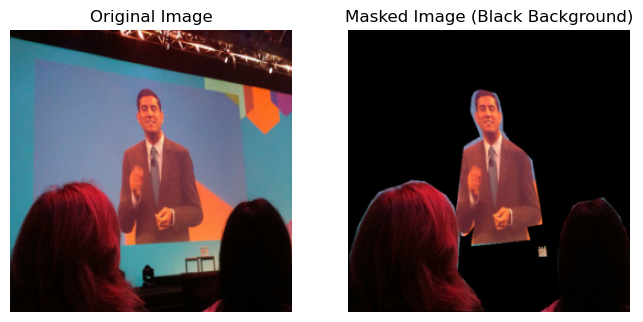

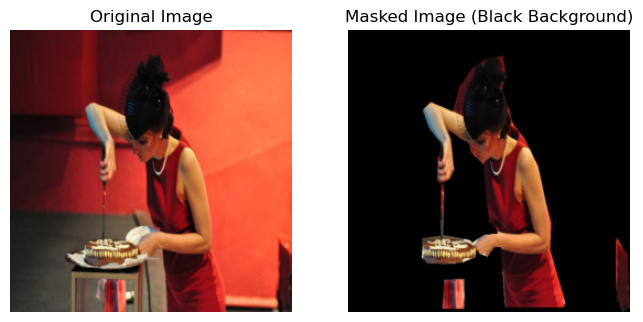

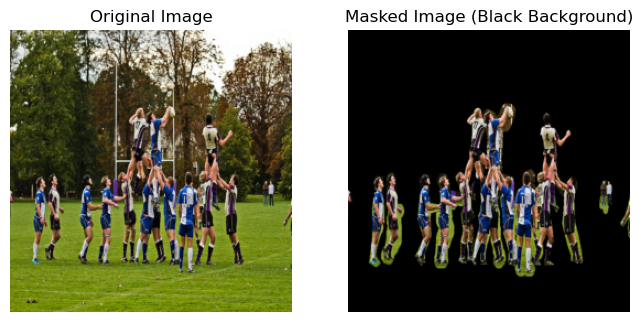

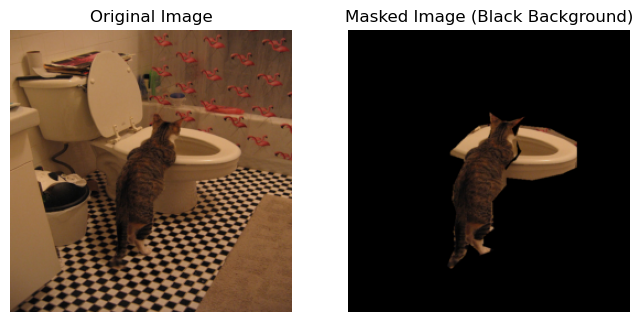

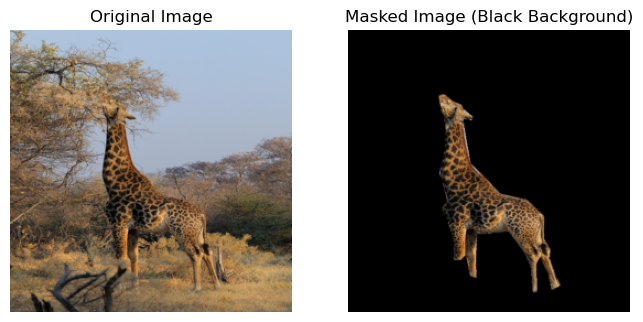

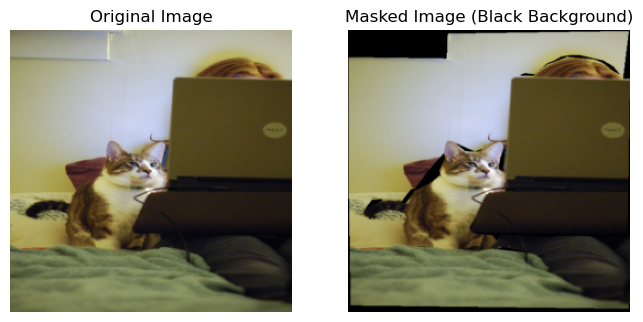

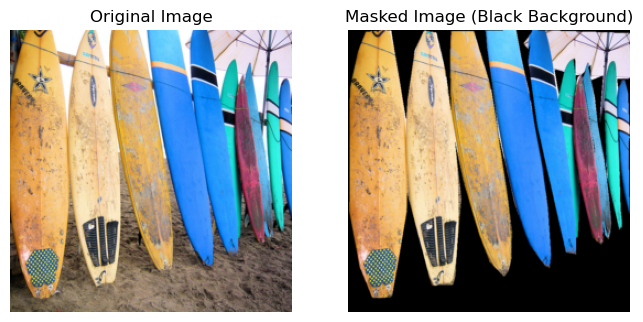

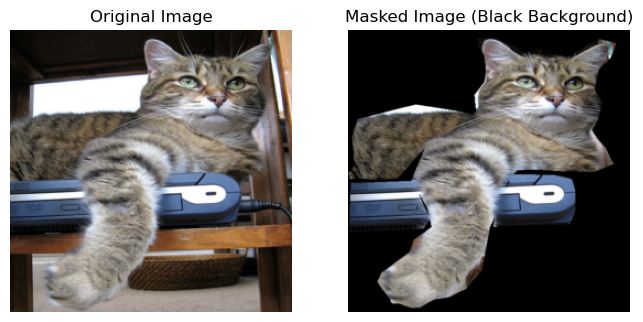

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO


class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.coco = COCO(annotations_path)
        self.img_ids = self.coco.getImgIds()
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.images_path, img_info['file_name'])

        img = Image.open(img_path).convert("RGB")
        img_arr = np.array(img)
       
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros(img_arr.shape[:2], dtype=np.uint8)
        for ann in anns:
            m = self.coco.annToMask(ann)
            mask = np.maximum(mask, m * 255)

        masked_img = np.zeros_like(img_arr)
        masked_img[mask > 0] = img_arr[mask > 0]

        original_pil = Image.fromarray(img_arr)
        masked_pil = Image.fromarray(masked_img)

        if self.transform:
            original_tensor = self.transform(original_pil)
            masked_tensor = self.transform(masked_pil)
        else:
            transform = transforms.ToTensor()
            original_tensor = transform(original_pil)
            masked_tensor = transform(masked_pil)

        return original_tensor, masked_tensor

images_path = r"D:\val2017\val2017"
annotations_path = r"D:\annotations_trainval2017\annotations\instances_val2017.json"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = CocoMaskedDataset(images_path, annotations_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

shown = 0
for orig_batch, masked_batch in dataloader:
    batch_size = orig_batch.size(0)

    for i in range(batch_size):
        orig_img = transforms.ToPILImage()(orig_batch[i])
        masked_img = transforms.ToPILImage()(masked_batch[i])

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(orig_img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(masked_img)
        plt.title("Masked Image (Black Background)")
        plt.axis("off")

        plt.show()

        shown += 1
        if shown >= 8:
            break

    if shown >= 8:
        break
